# Vaex - Polars Demo

# Install the Vaex and Polars libraries

In [75]:
pip install --upgrade polars

  Using cached polars-0.8.13-cp36-abi3-macosx_10_7_x86_64.whl (9.6 MB)
  Attempting uninstall: polars
    Found existing installation: polars 0.8.10
    Uninstalling polars-0.8.10:
      Successfully uninstalled polars-0.8.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
py-polars 0.8.10 requires polars==0.8.10, but you have polars 0.8.13 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [74]:
# conda install -c conda-forge vaex

SyntaxError: invalid syntax (<ipython-input-74-5ce5f80b23d1>, line 2)

In [8]:
pip install py-polars

  Using cached polars-0.8.10-cp36-abi3-macosx_10_7_x86_64.whl (10.1 MB)
  Attempting uninstall: polars
    Found existing installation: polars 0.8.13
    Uninstalling polars-0.8.13:
      Successfully uninstalled polars-0.8.13
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install vaex

Note: you may need to restart the kernel to use updated packages.


# Import the Vaex and Polars library

In [10]:
%matplotlib inline

import os
import json
import pandas as pd
import polars as pl
import vaex as vx
import pylab as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

# Data loading comparison Pandas, Vaex, Polars

### Small dataset

In [11]:
from google.oauth2 import service_account
from google.cloud import bigquery

# bq_credentials = service_account.Credentials.from_service_account_info(json.loads(os.environ['GBQ_SERVICE_ACCOUNT']))
bq_credentials = service_account.Credentials.from_service_account_file('aha-move-dbt_cloud.json')
bq_client = bigquery.Client(credentials=bq_credentials, project=bq_credentials.project_id)

query = bq_client.query('SELECT "Connection successful"')
for row in query.result():
    print(row[0])


Connection successful


In [12]:
query = """
    WITH PIT45 as (select date_trunc(date(complete_time),month) as period, supplier_id,
    sum((total_fee
    -coalesce(CAST(json_extract_scalar(extra, '$.no_com_request_fee') AS FLOAT64),0)
    -(supplier_bonus_account+supplier_main_account))/0.955) as driver_income
    from ahamove_archive.order_archive o
    where date(order_time) >= DATE_SUB(date('2021-01-01'), INTERVAL 5 DAY)
    and date(order_time) <= date('2021-05-31')
    and date(complete_time) >= DATE('2021-01-01')
    and date(complete_time) <=  date('2021-05-31')
    and status = 'COMPLETED'
    and service_id not in ('DAD-PARTNER-TCH',
    'HAN-PARTNER-TCH','SGN-PARTNER-TCH',
    'SGN-LOGS-5000',
    'SGN-PARTNER-TCH',
    'SGN-TRANS-2500',
    'SGN-TRANS-LCL',
    'HAN-SAMEDAY-TEST',
    'SGN-BIKE-TEST',
    'HAN-INTERCT-GHN',
    'HPH-PARTNER-TCH',
    'SGN-INTERCT-GHN',
    'SGN-TRANS-LCL',
    'VTG-PARTNER-TCH',
    'SGN-TRUCK-TEST', 
    'HNM_DUNGTIEN',
    'HPH_TUANVIET',
    'KEP_THOATHINH',
    'SGN-PARTNER-1D',
    'TBH_TTH')
    and service_id not like '%PARTNER%'
    group by 1,2),

    PIT101 as (select date_trunc(date(time),month) as period, supplier_id,
    coalesce (sum(case when (p.pit_code = 'PIT10' or type = 'REFERRAL') then amount end ),0) as net_PIT10,
    coalesce (sum(case when p.pit_code = 'PIT1' then amount end),0) as net_PIT1
    from ahamove_archive.supplier_transaction s
    left join ahamove_archive.policy p on p.id = s.policy_id
    where date(time) >= DATE('2021-01-01')
    and date(time) <=  date('2021-05-31')
    and type in ('REFILL','REWARD','RECALL','WITHDRAWAL','REFERRAL')
    and (p.pit_code in ('PIT10','PIT1') or type = 'REFERRAL')
    and order_id is null
    and amount != 0
    group by 1,2

    ),


    A as (
    select coalesce(p.period,p1.period) as period, coalesce(p.supplier_id,p1.supplier_id) as supplier_id,
    coalesce(driver_income,0) as driver_income,
    coalesce(net_PIT1,0) as net_bonus_pit1,
    coalesce(net_PIT10,0) as net_bonus_pit10 ,
    coalesce(driver_income,0)*0.045 as pit45, coalesce((net_PIT1/0.99)*0.01,0) as PIT1,
    coalesce (case when (net_PIT10/0.9) >= 2000000 then ((net_PIT10/0.9)*0.1) else 0 end,0) as PIT10
    from PIT45 p
    full outer join PIT101 p1 on (p.period = p1.period and p.supplier_id = p1.supplier_id)
    where true 
    )

    select  CONCAT(supplier_id,"_",FORMAT_DATE("%m%Y",period)) as id ,A.* ,s.name, s.account_status, s.tags, json_extract_scalar(extra, '$.tax_id_number') as tax_id_number, tax_id as tax_id, city_id
    from A
    left join ahamove_archive.supplier s on s.id = A.supplier_id
    order by supplier_id,period asc
    """
query_job = bq_client.query(query)
df = query_job.to_dataframe()

In [13]:
df.to_csv('test_df.csv')

In [14]:
import pandas as pd
import vaex as vx
import polars as pl

In [15]:
%%time

# pandas
pandas_df = pd.read_csv('./test_df.csv')

pandas_df.shape

CPU times: user 255 ms, sys: 24.1 ms, total: 280 ms
Wall time: 287 ms


(145515, 16)

In [16]:
%%time

# vaex
vaex_df = vx.from_csv('./test_df.csv')

vaex_df.shape

CPU times: user 388 ms, sys: 30.8 ms, total: 419 ms
Wall time: 422 ms


(145515, 16)

In [17]:
%%time

# polars
polars_df = pl.read_csv('./test_df.csv')

polars_df.shape

CPU times: user 111 ms, sys: 67.2 ms, total: 178 ms
Wall time: 88.1 ms


(145515, 16)

### => Data loading comparison (from slowest to fastest):

Vaex < Pandas < Polars


# Data conditional filter comparison

In [18]:
vaex_df.head()

#,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
0,0,--,2021-02-01,nan,0,0,0,0,0,0,--,--,--,nan,--,--
1,1,60328852083_012021,2021-01-01,6.03289e+10,0,0,42,0,0,0,Nhữ Đình Thái,ACTIVATED,--,nan,--,HAN
2,2,60346962542_012021,2021-01-01,6.0347e+10,0,0,42,0,0,0,Ngô Đức Thanh Tùng,ACTIVATED,--,nan,--,SGN
3,3,60349719227_032021,2021-03-01,6.03497e+10,0,0,42,0,0,0,Phạm Văn Hưởng,ACTIVATED,--,nan,--,HAN
4,4,60355520215_032021,2021-03-01,6.03555e+10,0,0,42,0,0,0,Lê Hồng Tâm,ACTIVATED,--,nan,--,SGN
5,5,60357826313_012021,2021-01-01,6.03578e+10,0,0,42,0,0,0,Đinh Thị Liễu,ACTIVATED,--,nan,--,HAN
6,6,60368439072_012021,2021-01-01,6.03684e+10,0,0,42,0,0,0,Nguyễn Đăng Tiến,ACTIVATED,--,nan,--,HAN
7,7,60369739812_012021,2021-01-01,6.03697e+10,0,0,42,0,0,0,Vũ Hải Phong,ACTIVATED,--,nan,--,SGN
8,8,60869372724_012021,2021-01-01,6.08694e+10,0,0,84,0,0,0,Phan Văn Lương,ACTIVATED,--,nan,--,HAN
9,9,60869372724_032021,2021-03-01,6.08694e+10,0,0,42,0,0,0,Phan Văn Lương,ACTIVATED,--,nan,--,HAN


In [19]:
pandas_df = pandas_df[1:]
pandas_df.head()

vaex_df = vaex_df[1:]
vaex_df.head()

polars_df = polars_df[1:]
polars_df.head()

,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
i64,str,date32,i64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
1,"""60328852083_012021""",2021-01-01,60328852083,0.0,0.0,42,0.0,0.0,0.0,"""Nhữ Đình Thái""","""ACTIVATED""","""""","""""","""""","""HAN"""
2,"""60346962542_012021""",2021-01-01,60346962542,0.0,0.0,42,0.0,0.0,0.0,"""Ngô Đức Thanh Tùng""","""ACTIVATED""","""""","""""","""""","""SGN"""
3,"""60349719227_032021""",2021-03-01,60349719227,0.0,0.0,42,0.0,0.0,0.0,"""Phạm Văn Hưởng""","""ACTIVATED""","""""","""""","""""","""HAN"""
4,"""60355520215_032021""",2021-03-01,60355520215,0.0,0.0,42,0.0,0.0,0.0,"""Lê Hồng Tâm""","""ACTIVATED""","""""","""""","""""","""SGN"""
5,"""60357826313_012021""",2021-01-01,60357826313,0.0,0.0,42,0.0,0.0,0.0,"""Đinh Thị Liễu ""","""ACTIVATED""","""""","""""","""""","""HAN"""


### Filter columns/rows

In [20]:
%%time

pandas_df.iloc[:5]

CPU times: user 73 µs, sys: 1e+03 ns, total: 74 µs
Wall time: 76.1 µs


,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
1,1,60328852083_012021,2021-01-01,6.032885e+10,0.0,0.0,42.0,0.0,0.0,0.0,Nhữ Đình Thái,ACTIVATED,NaN,NaN,NaN,HAN
2,2,60346962542_012021,2021-01-01,6.034696e+10,0.0,0.0,42.0,0.0,0.0,0.0,Ngô Đức Thanh Tùng,ACTIVATED,NaN,NaN,NaN,SGN
3,3,60349719227_032021,2021-03-01,6.034972e+10,0.0,0.0,42.0,0.0,0.0,0.0,Phạm Văn Hưởng,ACTIVATED,NaN,NaN,NaN,HAN
4,4,60355520215_032021,2021-03-01,6.035552e+10,0.0,0.0,42.0,0.0,0.0,0.0,Lê Hồng Tâm,ACTIVATED,NaN,NaN,NaN,SGN
5,5,60357826313_012021,2021-01-01,6.035783e+10,0.0,0.0,42.0,0.0,0.0,0.0,Đinh Thị Liễu,ACTIVATED,NaN,NaN,NaN,HAN


In [21]:
%%time

polars_df.slice(0,5)

CPU times: user 27 µs, sys: 1e+03 ns, total: 28 µs
Wall time: 28.8 µs


,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
i64,str,date32,i64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
1,"""60328852083_012021""",2021-01-01,60328852083,0.0,0.0,42,0.0,0.0,0.0,"""Nhữ Đình Thái""","""ACTIVATED""","""""","""""","""""","""HAN"""
2,"""60346962542_012021""",2021-01-01,60346962542,0.0,0.0,42,0.0,0.0,0.0,"""Ngô Đức Thanh Tùng""","""ACTIVATED""","""""","""""","""""","""SGN"""
3,"""60349719227_032021""",2021-03-01,60349719227,0.0,0.0,42,0.0,0.0,0.0,"""Phạm Văn Hưởng""","""ACTIVATED""","""""","""""","""""","""HAN"""
4,"""60355520215_032021""",2021-03-01,60355520215,0.0,0.0,42,0.0,0.0,0.0,"""Lê Hồng Tâm""","""ACTIVATED""","""""","""""","""""","""SGN"""
5,"""60357826313_012021""",2021-01-01,60357826313,0.0,0.0,42,0.0,0.0,0.0,"""Đinh Thị Liễu ""","""ACTIVATED""","""""","""""","""""","""HAN"""


In [22]:
%%time

vaex_df[:5]

CPU times: user 955 µs, sys: 162 µs, total: 1.12 ms
Wall time: 993 µs


#,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
0,1,60328852083_012021,2021-01-01,6.03289e+10,0,0,42,0,0,0,Nhữ Đình Thái,ACTIVATED,--,nan,--,HAN
1,2,60346962542_012021,2021-01-01,6.0347e+10,0,0,42,0,0,0,Ngô Đức Thanh Tùng,ACTIVATED,--,nan,--,SGN
2,3,60349719227_032021,2021-03-01,6.03497e+10,0,0,42,0,0,0,Phạm Văn Hưởng,ACTIVATED,--,nan,--,HAN
3,4,60355520215_032021,2021-03-01,6.03555e+10,0,0,42,0,0,0,Lê Hồng Tâm,ACTIVATED,--,nan,--,SGN
4,5,60357826313_012021,2021-01-01,6.03578e+10,0,0,42,0,0,0,Đinh Thị Liễu,ACTIVATED,--,nan,--,HAN


### => Filter by columns/ rows (from slowest to fastest):
Vaex < Pandas < Polars


### Filter by conditions

In [23]:
%%time

pandas_df[pandas_df['id'].str.contains('6034')]

CPU times: user 57.9 ms, sys: 1.46 ms, total: 59.3 ms
Wall time: 59.8 ms


,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
2,2,60346962542_012021,2021-01-01,6.034696e+10,0.000000e+00,0.0,42.0,0.000000,0.000000,0.0,Ngô Đức Thanh Tùng,ACTIVATED,NaN,NaN,NaN,SGN
3,3,60349719227_032021,2021-03-01,6.034972e+10,0.000000e+00,0.0,42.0,0.000000,0.000000,0.0,Phạm Văn Hưởng,ACTIVATED,NaN,NaN,NaN,HAN
24347,24347,84373260347_042021,2021-04-01,8.437326e+10,3.312000e+05,0.0,0.0,14904.000000,0.000000,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
24348,24348,84373260347_052021,2021-05-01,8.437326e+10,5.944000e+05,0.0,0.0,26748.000000,0.000000,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
29763,29763,84383603412_012021,2021-01-01,8.438360e+10,1.056960e+06,0.0,0.0,47563.199991,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29764,29764,84383603412_022021,2021-02-01,8.438360e+10,2.275840e+06,0.0,0.0,102412.800009,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29765,29765,84383603412_032021,2021-03-01,8.438360e+10,9.080000e+05,0.0,0.0,40860.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29766,29766,84383603412_042021,2021-04-01,8.438360e+10,2.800000e+04,0.0,0.0,1260.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29767,29767,84383603412_052021,2021-05-01,8.438360e+10,1.904000e+05,0.0,0.0,8568.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
31382,31382,84385956034_012021,2021-01-01,8.438596e+10,4.732000e+06,99000.0,0.0,212940.000000,1000.000000,0.0,Phạm Văn Long,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",001201028524,8638700938,HAN


In [24]:
%%time

vaex_df[vaex_df['id'].str.contains('6034')]

CPU times: user 864 µs, sys: 261 µs, total: 1.12 ms
Wall time: 2.26 ms


#,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
0,2,60346962542_012021,2021-01-01,60346962542.0,0.0,0.0,42.0,0.0,0.0,0.0,Ngô Đức Thanh Tùng,ACTIVATED,--,nan,--,SGN
1,3,60349719227_032021,2021-03-01,60349719227.0,0.0,0.0,42.0,0.0,0.0,0.0,Phạm Văn Hưởng,ACTIVATED,--,nan,--,HAN
2,24347,84373260347_042021,2021-04-01,84373260347.0,331200.0,0.0,0.0,14904.0,0.0,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
3,24348,84373260347_052021,2021-05-01,84373260347.0,594400.0,0.0,0.0,26748.0,0.0,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
4,29763,84383603412_012021,2021-01-01,84383603412.0,1056959.9997954844,0.0,0.0,47563.19999079679,0.0,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,40320,84986034069_022021,2021-02-01,84986034069.0,21600.0,0.0,0.0,972.0,0.0,0.0,Vòong Linh Đông,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",13013691.0,8418187220,HAN
50,40321,84986034069_032021,2021-03-01,84986034069.0,14400.0,0.0,0.0,648.0,0.0,0.0,Vòong Linh Đông,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",13013691.0,8418187220,HAN
51,40322,84986034069_052021,2021-05-01,84986034069.0,76000.0,0.0,0.0,3420.0,0.0,0.0,Vòong Linh Đông,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",13013691.0,8418187220,HAN
52,40323,84986034145_052021,2021-05-01,84986034145.0,333600.0,0.0,0.0,15012.0,0.0,0.0,Trần Thuận Nghĩa,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",341988784.0,8705539973,SGN


In [25]:
# not work with polars

polars_df[polars_df['id'].str.contains('6034')]

,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
i64,str,date32,i64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
2,"""60346962542_012021""",2021-01-01,60346962542,0.0,0.0,42,0.0,0.0,0.0,"""Ngô Đức Thanh Tùng""","""ACTIVATED""","""""","""""","""""","""SGN"""
3,"""60349719227_032021""",2021-03-01,60349719227,0.0,0.0,42,0.0,0.0,0.0,"""Phạm Văn Hưởng""","""ACTIVATED""","""""","""""","""""","""HAN"""
24347,"""84373260347_042021""",2021-04-01,84373260347,3.312e5,0.0,0.0,1.4904e4,0.0,0.0,"""Hoàng Quốc Hay""","""ACTIVATED""","""[""FL"", ""RECPSGN"", ""SGN""]""","""036201003552""","""8650020079""","""SGN"""
24348,"""84373260347_052021""",2021-05-01,84373260347,5.944e5,0.0,0.0,2.6748e4,0.0,0.0,"""Hoàng Quốc Hay""","""ACTIVATED""","""[""FL"", ""RECPSGN"", ""SGN""]""","""036201003552""","""8650020079""","""SGN"""
29763,"""84383603412_012021""",2021-01-01,84383603412,1.0569599997954844e6,0.0,0.0,4.756319999079679e4,0.0,0.0,"""Trần Đức Lâm""","""ACTIVATED""","""[""FL"", ""TEST_QR"", ""HAN""]""","""036091009568""","""8631266373""","""HAN"""
29764,"""84383603412_022021""",2021-02-01,84383603412,2.2758400002045156e6,0.0,0.0,1.024128000092032e5,0.0,0.0,"""Trần Đức Lâm""","""ACTIVATED""","""[""FL"", ""TEST_QR"", ""HAN""]""","""036091009568""","""8631266373""","""HAN"""
29765,"""84383603412_032021""",2021-03-01,84383603412,9.08e5,0.0,0.0,4.086e4,0.0,0.0,"""Trần Đức Lâm""","""ACTIVATED""","""[""FL"", ""TEST_QR"", ""HAN""]""","""036091009568""","""8631266373""","""HAN"""
29766,"""84383603412_042021""",2021-04-01,84383603412,2.8e4,0.0,0.0,1260,0.0,0.0,"""Trần Đức Lâm""","""ACTIVATED""","""[""FL"", ""TEST_QR"", ""HAN""]""","""036091009568""","""8631266373""","""HAN"""
29767,"""84383603412_052021""",2021-05-01,84383603412,1.904e5,0.0,0.0,8568,0.0,0.0,"""Trần Đức Lâm""","""ACTIVATED""","""[""FL"", ""TEST_QR"", ""HAN""]""","""036091009568""","""8631266373""","""HAN"""


In [26]:
dir(polars_df)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_df',
 '_from_pydf',
 '_pos_idx',
 '_repr_html_',
 'apply',
 'clone',
 'columns',
 'describe',
 'downsample',
 'drop',
 'drop_duplicates',
 'drop_in_place',
 'drop_nulls',
 'dtypes',
 'explode',
 'fill_none',
 'filter',
 'find_idx_by_name',
 'fold',
 'frame_equal',
 'from_arrow',
 'from_rows',
 'get_columns',
 'groupby',
 'head',
 'height',
 'hstack',
 'insert_at_idx',
 'is_duplicated',
 'is_unique',
 'join',
 'lazy',
 'limit',
 'max',
 'mean',
 'median',
 'melt',
 'min',
 'n_chunks',
 'null_count'

In [27]:
polars_df1= polars_df.clone()
polars_df1 = polars_df1.to_pandas()

In [28]:
%%time

polars_df1[polars_df1['id'].str.contains('6034')]

CPU times: user 56.1 ms, sys: 2.58 ms, total: 58.7 ms
Wall time: 58.8 ms


,,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
1,2,60346962542_012021,2021-01-01,60346962542,0.000000e+00,0.0,42.0,0.000000,0.000000,0.0,Ngô Đức Thanh Tùng,ACTIVATED,,,,SGN
2,3,60349719227_032021,2021-03-01,60349719227,0.000000e+00,0.0,42.0,0.000000,0.000000,0.0,Phạm Văn Hưởng,ACTIVATED,,,,HAN
24346,24347,84373260347_042021,2021-04-01,84373260347,3.312000e+05,0.0,0.0,14904.000000,0.000000,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
24347,24348,84373260347_052021,2021-05-01,84373260347,5.944000e+05,0.0,0.0,26748.000000,0.000000,0.0,Hoàng Quốc Hay,ACTIVATED,"[""FL"", ""RECPSGN"", ""SGN""]",036201003552,8650020079,SGN
29762,29763,84383603412_012021,2021-01-01,84383603412,1.056960e+06,0.0,0.0,47563.199991,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29763,29764,84383603412_022021,2021-02-01,84383603412,2.275840e+06,0.0,0.0,102412.800009,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29764,29765,84383603412_032021,2021-03-01,84383603412,9.080000e+05,0.0,0.0,40860.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29765,29766,84383603412_042021,2021-04-01,84383603412,2.800000e+04,0.0,0.0,1260.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
29766,29767,84383603412_052021,2021-05-01,84383603412,1.904000e+05,0.0,0.0,8568.000000,0.000000,0.0,Trần Đức Lâm,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",036091009568,8631266373,HAN
31381,31382,84385956034_012021,2021-01-01,84385956034,4.732000e+06,99000.0,0.0,212940.000000,1000.000000,0.0,Phạm Văn Long,ACTIVATED,"[""FL"", ""TEST_QR"", ""HAN""]",001201028524,8638700938,HAN


### => Filter by conditions (from slowest to fastest):
Polars < Pandas < Vaex

# Aggregate functions comparison

In [29]:
pandas_df.head()

,Unnamed: 0,id,period,supplier_id,driver_income,net_bonus_pit1,net_bonus_pit10,pit45,PIT1,PIT10,name,account_status,tags,tax_id_number,tax_id,city_id
1,1,60328852083_012021,2021-01-01,6.032885e+10,0.0,0.0,42.0,0.0,0.0,0.0,Nhữ Đình Thái,ACTIVATED,NaN,NaN,NaN,HAN
2,2,60346962542_012021,2021-01-01,6.034696e+10,0.0,0.0,42.0,0.0,0.0,0.0,Ngô Đức Thanh Tùng,ACTIVATED,NaN,NaN,NaN,SGN
3,3,60349719227_032021,2021-03-01,6.034972e+10,0.0,0.0,42.0,0.0,0.0,0.0,Phạm Văn Hưởng,ACTIVATED,NaN,NaN,NaN,HAN
4,4,60355520215_032021,2021-03-01,6.035552e+10,0.0,0.0,42.0,0.0,0.0,0.0,Lê Hồng Tâm,ACTIVATED,NaN,NaN,NaN,SGN
5,5,60357826313_012021,2021-01-01,6.035783e+10,0.0,0.0,42.0,0.0,0.0,0.0,Đinh Thị Liễu,ACTIVATED,NaN,NaN,NaN,HAN


In [30]:
%%time

pandas_df['driver_income'].groupby(level = 0).mean()

CPU times: user 2.42 ms, sys: 1.68 ms, total: 4.1 ms
Wall time: 4.73 ms


1               0.0
2               0.0
3               0.0
4               0.0
5               0.0
            ...    
145510     233600.0
145511      35200.0
145512     688800.0
145513    3362400.0
145514    1876800.0
Name: driver_income, Length: 145514, dtype: float64

In [31]:
%%time

#to_pandas()

polars_df1['driver_income'].groupby(level = 0).mean()

CPU times: user 2.93 ms, sys: 666 µs, total: 3.6 ms
Wall time: 2.92 ms


0               0.0
1               0.0
2               0.0
3               0.0
4               0.0
            ...    
145509     233600.0
145510      35200.0
145511     688800.0
145512    3362400.0
145513    1876800.0
Name: driver_income, Length: 145514, dtype: float64

In [32]:
#to_pandas_df()

vaex_df1 = vaex_df.copy()
vaex_df1 = vaex_df1.to_pandas_df()
type(vaex_df1)

pandas.core.frame.DataFrame

In [33]:
%%time

vaex_df1['driver_income'].groupby(level = 0).mean()

CPU times: user 1.92 ms, sys: 1.15 ms, total: 3.07 ms
Wall time: 2.31 ms


0               0.0
1               0.0
2               0.0
3               0.0
4               0.0
            ...    
145509     233600.0
145510      35200.0
145511     688800.0
145512    3362400.0
145513    1876800.0
Name: driver_income, Length: 145514, dtype: float64

### => Groupby function
Same for the 3 libraries

In [34]:
%%time

pandas_df['period'].value_counts()

CPU times: user 9.43 ms, sys: 585 µs, total: 10 ms
Wall time: 11.1 ms


2021-03-01    30383
2021-04-01    29810
2021-05-01    29763
2021-01-01    29640
2021-02-01    25918
Name: period, dtype: int64

In [35]:
%%time

polars_df['period'].value_counts()

CPU times: user 3.57 ms, sys: 3.07 ms, total: 6.63 ms
Wall time: 6.82 ms


period,counts
i32,u32
18687,30383
18718,29810
18748,29763
18628,29640
18659,25918


In [36]:
%%time

vaex_df['period'].value_counts()

CPU times: user 14.9 ms, sys: 2.94 ms, total: 17.8 ms
Wall time: 12.2 ms


2021-03-01    30383
2021-04-01    29810
2021-05-01    29763
2021-01-01    29640
2021-02-01    25918
dtype: int64

### => Aggregate function (from slowest to fastest):
Vaex < Pandas < Polars

# Big Dataset with 146 Million Rows (12 GB)
#### Datasets expamples: https://vaex.io/docs/datasets.html
#### HDF5 format: https://www.neonscience.org/resources/learning-hub/tutorials/about-hdf5

### Vaex - Polars popularity comparison
##### https://github.com/vaexio/vaex
##### https://github.com/pola-rs/polars

In [37]:
%%time

taxi1 = vx.open('s3://vaex/taxi/yellow_taxi_2015_f32s.hdf5?anon=true')

CPU times: user 343 ms, sys: 179 ms, total: 522 ms
Wall time: 8.03 s


In [38]:
taxi1 = vx.open('s3://vaex/taxi/yellow_taxi_2015_f32s.hdf5?anon=true')
taxi1

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2014-12-16 02:26:00.000000000,2014-12-16 02:28:00.000000000,1,CSH,1.09,-73.986725,40.75642,1.0,nan,-73.99646,40.742893,5.0,0.5,0.5,0.0,0.0,6.0
1,VTS,2014-12-15 18:23:00.000000000,2014-12-15 18:58:00.000000000,2,,6.28,-74.00419,40.72119,1.0,nan,-73.97,nan,nan,nan,nan,nan,nan,nan
2,VTS,2015-01-15 19:05:39.000000000,2015-01-15 19:23:42.000000000,1,1,1.59,-73.9939,40.75011,1.0,0.0,-73.974785,40.750618,12.0,1.0,0.5,3.25,0.0,17.05
3,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:53:28.000000000,1,1,3.3,-74.00165,40.724243,1.0,0.0,-73.994415,40.75911,14.5,0.5,0.5,2.0,0.0,17.8
4,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:43:41.000000000,1,2,1.8,-73.96334,40.802788,1.0,0.0,-73.95182,40.824413,9.5,0.5,0.5,0.0,0.0,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"146,112,986",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2,-73.99381,40.72087,1.0,0.0,-73.98621,40.72247,7.5,0.5,0.5,1.76,0.0,10.56
"146,112,987",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527,40.76028,1.0,0.0,-73.939514,40.752388,7.5,0.5,0.5,0.0,0.0,8.8
"146,112,988",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.8,-73.9873,40.73908,1.0,0.0,-73.98867,40.6933,13.5,0.5,0.5,0.0,0.0,14.8
"146,112,989",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.96,-73.99756,40.725693,1.0,0.0,-74.01712,40.705322,8.5,0.5,0.5,0.0,0.0,9.8


In [39]:
taxi1.shape

(146112991, 18)

## Now try convert to Pandas df format

In [40]:
taxi1.to_pandas_df()
type(taxi1)

vaex.dataframe.DataFrameLocal

In [42]:
taxi1.extract().export_csv('taxi1.csv')

In [80]:
# taxi1a = taxi1.read_csv('taxi1.csv')
taxi1a = vx.from_csv('taxi1.csv')

# Read Dataset with 1.1 Billion Rows (107 GB)

In [45]:
import vaex as vx

In [46]:
%%time
taxi2 = vx.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')

CPU times: user 176 ms, sys: 161 ms, total: 337 ms
Wall time: 21.1 s


In [47]:
taxi2

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.99196,40.721565,nan,nan,-73.993805,40.695923,8.9,0.5,nan,0.0,0.0,9.4
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.73629,nan,nan,-73.95585,40.76803,12.1,0.5,nan,2.0,0.0,14.6
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.35,-74.00259,40.739746,nan,nan,-73.86998,40.770226,23.7,0.0,nan,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.974266,40.790955,nan,nan,-73.99656,40.73185,14.9,0.5,nan,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.00158,40.719383,nan,nan,-74.00838,40.72035,3.7,0.0,nan,0.0,0.0,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2,-73.99381,40.72087,1.0,0.0,-73.98621,40.72247,7.5,0.5,0.5,1.76,0.0,10.56
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527,40.76028,1.0,0.0,-73.939514,40.752388,7.5,0.5,0.5,0.0,0.0,8.8
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.8,-73.9873,40.73908,1.0,0.0,-73.98867,40.6933,13.5,0.5,0.5,0.0,0.0,14.8
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.96,-73.99756,40.725693,1.0,0.0,-74.01712,40.705322,8.5,0.5,0.5,0.0,0.0,9.8


# Manipulate data with Vaex

### Remove missing value

In [48]:
taxi1 = taxi1.dropna(column_names = ['dropoff_latitude','dropoff_longitude','pickup_latitude'])

### Abnormal number of passengers

In [49]:
taxi1.passenger_count.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     4.81s =  0.1m =  0.0h
 

1    102991046
2     20901372
5      7939001
3      6135107
6      5123951
4      2981071
0        40853
7          239
8          181
9          169
dtype: int64

### Number of passenger

In [50]:
taxi1.passenger_count.unique()

[1, 2, 4, 3, 5, 6, 0, 8, 7, 9]

In [51]:
taxi1 = taxi1[(taxi1.passenger_count > 0) & (taxi1.passenger_count < 7)]

In [52]:
taxi1.trip_distance.values

array([1.09, 1.59, 3.3 , ..., 3.8 , 1.96, 1.06], dtype=float32)

### Longest distance

In [53]:
max_trip_distance = taxi1.trip_distance.max()
print(f'{max_trip_distance:,},miles.') 

198,623,008.0,miles.


### Visualizing the NYC Taxi dataset
#### For more info: https://vaex.io/docs/tutorial.html#Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

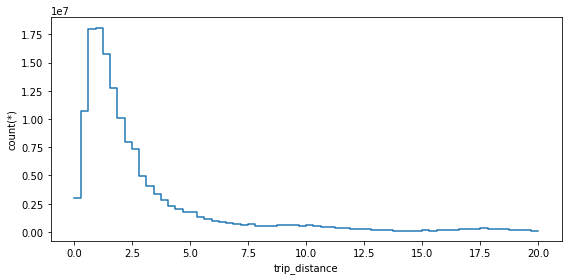

In [54]:
# Visualize Trip distance distribution

import pylab as plt
plt.figure(figsize = (8,4))
taxi1.plot1d('trip_distance', limits = [0,20])
plt.show

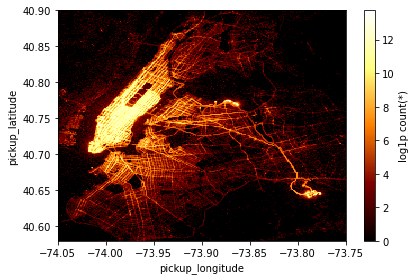

In [55]:
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

taxi1.plot(taxi1.pickup_longitude, taxi1.pickup_latitude, f="log1p", limits=[[-74.05, -73.75], [40.58, 40.90]], show=True);

### Create new features

In [56]:
import numpy as np

In [57]:
taxi1['trip_speed'] = taxi1.trip_distance / ((taxi1.dropoff_datetime - taxi1.pickup_datetime)/ np.timedelta64(1, 'h'))
taxi1['trip_duration_min'] = (taxi1.dropoff_datetime - taxi1.pickup_datetime)/ np.timedelta64(1, 'm')
taxi1['fare_by_distance'] = (taxi1.fare_amount / taxi1.trip_distance)

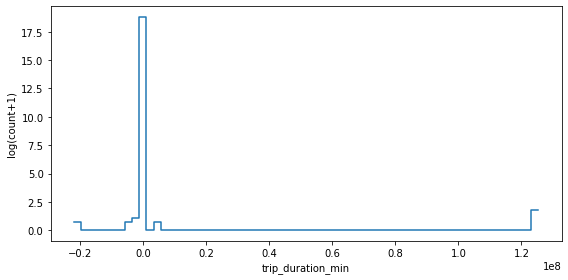

In [58]:
plt.figure(figsize = (8,4))
taxi1.plot1d('trip_duration_min', f="log1p", limits='minmax')
plt.ylabel('log(count+1)')
plt.show()

## Virtual columns

### 146M rows dataset

In [59]:
# not take any memory
taxi1['tip_percentage'] = taxi1.tip_amount/taxi1.total_amount

In [60]:
taxi1.tip_percentage

Expression = tip_percentage
Length: 146,071,548 dtype: float32 (column)
-------------------------------------------
        0         0
        1  0.190616
        2   0.11236
        3         0
        4         0
        ...        
146071543  0.166667
146071544         0
146071545         0
146071546         0
146071547  0.166667

In [61]:
taxi1

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed,trip_duration_min,fare_by_distance,tip_percentage
0,VTS,2014-12-16 02:26:00.000000000,2014-12-16 02:28:00.000000000,1,CSH,1.09,-73.986725,40.75642,1.0,nan,-73.99646,40.742893,5.0,0.5,0.5,0.0,0.0,6.0,32.70000100135803,2.0,4.587156,0.0
1,VTS,2015-01-15 19:05:39.000000000,2015-01-15 19:23:42.000000000,1,1,1.59,-73.9939,40.75011,1.0,0.0,-73.974785,40.750618,12.0,1.0,0.5,3.25,0.0,17.05,5.285318670510585,18.05,7.5471697,0.19061585
2,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:53:28.000000000,1,1,3.3,-74.00165,40.724243,1.0,0.0,-73.994415,40.75911,14.5,0.5,0.5,2.0,0.0,17.8,9.983193133057666,19.833333333333332,4.3939395,0.11235955
3,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:43:41.000000000,1,2,1.8,-73.96334,40.802788,1.0,0.0,-73.95182,40.824413,9.5,0.5,0.5,0.0,0.0,10.8,10.746268372037516,10.05,5.277778,0.0
4,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:35:31.000000000,1,2,0.5,-74.00909,40.713818,1.0,0.0,-74.004326,40.719986,3.5,0.5,0.5,0.0,0.0,4.8,16.071428571428573,1.8666666666666667,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"146,071,543",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2,-73.99381,40.72087,1.0,0.0,-73.98621,40.72247,7.5,0.5,0.5,1.76,0.0,10.56,8.605578031197961,8.366666666666667,6.2499995,0.16666666
"146,071,544",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527,40.76028,1.0,0.0,-73.939514,40.752388,7.5,0.5,0.5,0.0,0.0,8.8,22.429906542056074,5.35,3.75,0.0
"146,071,545",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.8,-73.9873,40.73908,1.0,0.0,-73.98867,40.6933,13.5,0.5,0.5,0.0,0.0,14.8,17.628865758168327,12.933333333333334,3.5526316,0.0
"146,071,546",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.96,-73.99756,40.725693,1.0,0.0,-74.01712,40.705322,8.5,0.5,0.5,0.0,0.0,9.8,11.253588735772093,10.45,4.336735,0.0


In [62]:
taxi1.mean(taxi1.tip_percentage)

array(0.09604216)

In [63]:
%%time

# this would cost 46+GB RAM using Pandas
print(taxi1[taxi1.tip_amount > 10].tip_percentage.mean())

0.19807236574844353
CPU times: user 647 ms, sys: 512 ms, total: 1.16 s
Wall time: 726 ms


## Datetime functions

In [64]:
# Daily activities
taxi1['pu_hour'] = taxi1.pickup_datetime.dt.hour
taxi1['pu_day_of_week'] = taxi1.pickup_datetime.dt.dayofweek
taxi1['pu_month'] = taxi1.pickup_datetime.dt.month
taxi1['pu_is_weekend'] = (taxi1.pu_day_of_week >=5).astype('int')

# Days labeling
weekday_names_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
month_names_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [65]:
# Treat these colums as label encoded values
taxi1.categorize(column = 'pu_hour', labels = list(map(str,range(24))))
taxi1.categorize(column = 'pu_day_of_week', labels = weekday_names_list)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed,trip_duration_min,fare_by_distance,tip_percentage,pu_hour,pu_day_of_week,pu_month,pu_is_weekend
0,VTS,2014-12-16 02:26:00.000000000,2014-12-16 02:28:00.000000000,1,CSH,1.09,-73.986725,40.75642,1.0,nan,-73.99646,40.742893,5.0,0.5,0.5,0.0,0.0,6.0,32.70000100135803,2.0,4.587156,0.0,2,1,12,0
1,VTS,2015-01-15 19:05:39.000000000,2015-01-15 19:23:42.000000000,1,1,1.59,-73.9939,40.75011,1.0,0.0,-73.974785,40.750618,12.0,1.0,0.5,3.25,0.0,17.05,5.285318670510585,18.05,7.5471697,0.19061585,19,3,1,0
2,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:53:28.000000000,1,1,3.3,-74.00165,40.724243,1.0,0.0,-73.994415,40.75911,14.5,0.5,0.5,2.0,0.0,17.8,9.983193133057666,19.833333333333332,4.3939395,0.11235955,20,5,1,1
3,CMT,2015-01-10 20:33:38.000000000,2015-01-10 20:43:41.000000000,1,2,1.8,-73.96334,40.802788,1.0,0.0,-73.95182,40.824413,9.5,0.5,0.5,0.0,0.0,10.8,10.746268372037516,10.05,5.277778,0.0,20,5,1,1
4,CMT,2015-01-10 20:33:39.000000000,2015-01-10 20:35:31.000000000,1,2,0.5,-74.00909,40.713818,1.0,0.0,-74.004326,40.719986,3.5,0.5,0.5,0.0,0.0,4.8,16.071428571428573,1.8666666666666667,7.0,0.0,20,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"146,071,543",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2,-73.99381,40.72087,1.0,0.0,-73.98621,40.72247,7.5,0.5,0.5,1.76,0.0,10.56,8.605578031197961,8.366666666666667,6.2499995,0.16666666,23,3,12,0
"146,071,544",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527,40.76028,1.0,0.0,-73.939514,40.752388,7.5,0.5,0.5,0.0,0.0,8.8,22.429906542056074,5.35,3.75,0.0,23,3,12,0
"146,071,545",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.8,-73.9873,40.73908,1.0,0.0,-73.98867,40.6933,13.5,0.5,0.5,0.0,0.0,14.8,17.628865758168327,12.933333333333334,3.5526316,0.0,23,3,12,0
"146,071,546",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.96,-73.99756,40.725693,1.0,0.0,-74.01712,40.705322,8.5,0.5,0.5,0.0,0.0,9.8,11.253588735772093,10.45,4.336735,0.0,23,3,12,0


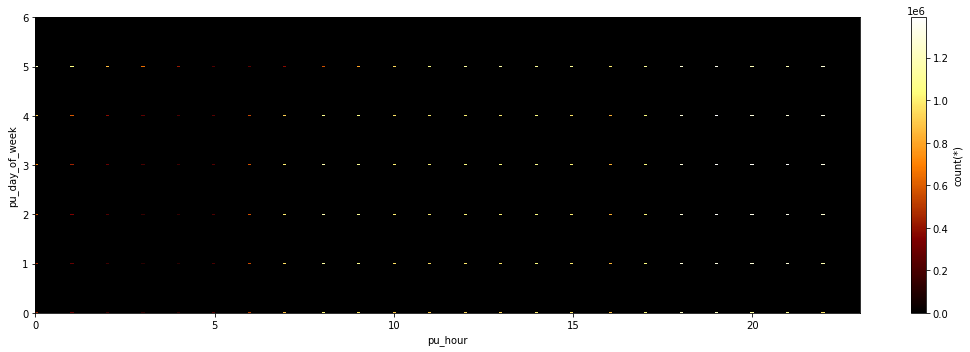

In [66]:
# Number of pickups per hour for a given day of week
taxi1.plot('pu_hour','pu_day_of_week', colorbar = True, figsize = (15,5))

### 1.1B rows dataset

In [67]:
taxi2['tip_percentage'] = taxi2.tip_amount/taxi2.total_amount

In [68]:
taxi2[taxi2.tip_amount > 10].tip_percentage.mean(progress=True)

[########################################] 100.00% elapsed time  :   569.26s =  9.5m =  0.2h
 

array(0.20606907)

In [69]:
taxi2

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.99196,40.721565,nan,nan,-73.993805,40.695923,8.9,0.5,nan,0.0,0.0,9.4,0.0
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.73629,nan,nan,-73.95585,40.76803,12.1,0.5,nan,2.0,0.0,14.6,0.1369863
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.35,-74.00259,40.739746,nan,nan,-73.86998,40.770226,23.7,0.0,nan,4.74,0.0,28.44,0.16666666
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.974266,40.790955,nan,nan,-73.99656,40.73185,14.9,0.5,nan,3.05,0.0,18.45,0.16531165
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.00158,40.719383,nan,nan,-74.00838,40.72035,3.7,0.0,nan,0.0,0.0,3.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2,-73.99381,40.72087,1.0,0.0,-73.98621,40.72247,7.5,0.5,0.5,1.76,0.0,10.56,0.16666666
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527,40.76028,1.0,0.0,-73.939514,40.752388,7.5,0.5,0.5,0.0,0.0,8.8,0.0
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.8,-73.9873,40.73908,1.0,0.0,-73.98867,40.6933,13.5,0.5,0.5,0.0,0.0,14.8,0.0
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.96,-73.99756,40.725693,1.0,0.0,-74.01712,40.705322,8.5,0.5,0.5,0.0,0.0,9.8,0.0


In [1]:
# taxi2.plot_widget(taxi2.pickup_longitude, taxi2.pickup_latitude, f='log', controls_selection=True)

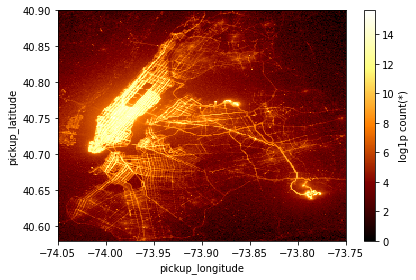

In [71]:
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

taxi2.plot(taxi2.pickup_longitude, taxi2.pickup_latitude, f="log1p", limits=[[-74.05, -73.75], [40.58, 40.90]], show=True);

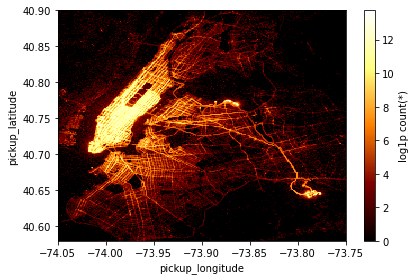

In [72]:
# Compare with 146M rows plot
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

taxi1.plot(taxi1.pickup_longitude, taxi1.pickup_latitude, f="log1p", limits=[[-74.05, -73.75], [40.58, 40.90]], show=True);

## References:
+ https://vaex.io
+ https://towardsdatascience.com/are-you-still-using-pandas-to-process-big-data-in-2021-850ab26ad919
+ https://www.neonscience.org/resources/learning-hub/tutorials/about-hdf5
+ https://h2oai.github.io/db-benchmark/
+ https://vaex.io/blog/beyond-pandas-spark-dask-vaex-and-other-big-data-technologies-battling-head-to-head
+ https://wesmckinney.com/blog/apache-arrow-pandas-internals/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=69d24e97-8877-4c8a-a7e5-eea30153b14c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>